In [47]:
import math
from torch import optim, nn
from functools import partial
from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
import wandb 
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['axes.grid'] = True

import sys
from pathlib import Path

# Add the 'src' folder to sys.path
sys.path.append(str(Path().resolve().parent / "src"))

from initialize import *
from classes import *
from train import *
from data_proc import *

In [48]:
api = wandb.Api()

In [49]:
results = []

def get_results(project_name):
    for i, run in tqdm(enumerate(api.runs(path=f"alexa_-ista/{project_name}", filters={}))):
        config = run.config
        history = run.scan_history()
        
        run_dict = defaultdict(lambda: [], config)
        run_dict['lr'] = []

        run_dict['run_name'] = run.name

        for row in history:
            for key, value in row.items():
                if isinstance(value, (int, float)):
                    run_dict[key].append(value)

        if len(run_dict['_step']) == 200 and config['num_epochs'] == 20:
            results.append(run_dict)

get_results('cil_replay')
get_results('cil_replay_const')
get_results('cil_replay_cyclic')

print(len(results))
    


45it [00:26,  1.73it/s]
2it [00:01,  1.77it/s]
2it [00:01,  1.69it/s]

48


In [50]:
len(results)

48

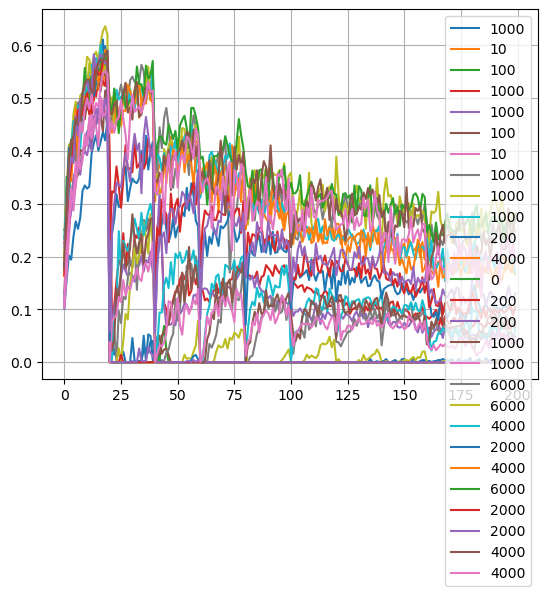

In [51]:
for run in results:
    if run['model'] == 'resnet':
        plt.plot(run['val_acc_0'], label=run['buffer'])
    plt.legend()

In [52]:
def smooth_values(y_values, x_values, range_of_x, smoothing_param):
    smoothing_weight = min(math.sqrt(smoothing_param or 0), 0.999)
    last_y = 0 if len(y_values) > 0 else float('nan')
    debias_weight = 0

    smoothed_values = []
    for index, y_point in enumerate(y_values):
        prev_x = index - 1 if index > 0 else 0
        # VIEWPORT_SCALE scales the result to the chart's x-axis range
        change_in_x = ((x_values[index] - x_values[prev_x]) / range_of_x) 
        smoothing_weight_adj = math.pow(smoothing_weight, change_in_x)

        last_y = last_y * smoothing_weight_adj + y_point
        debias_weight = debias_weight * smoothing_weight_adj + 1
        smoothed_values.append(last_y / debias_weight)
    
    return smoothed_values


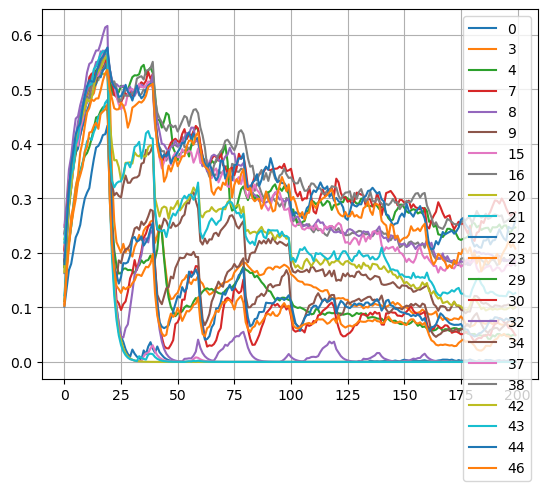

In [53]:
for i, run in enumerate(results):
    if run['model'] == 'resnet' and run['buffer'] > 100:
        y = run['val_acc_0']
        y_ema = smooth_values(y, run['_step'], 1, 0.4)

        plt.plot(y_ema, label=f'{i}')
plt.legend()


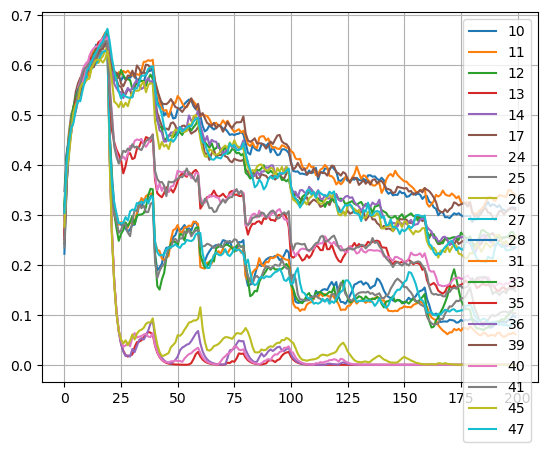

In [54]:
for i, run in enumerate(results):
    if run['model'] == 'vit' and run['buffer'] > 100:
        y = run['val_acc_0']
        y_ema = smooth_values(y, run['_step'], 1, 0.4)

        plt.plot(y_ema, label=f'{i}')
plt.legend()

In [55]:
def acc_matrix(run_ind):
    run = results[run_ind]
    acc = np.zeros((10, 10))

    for i in range(10):
        index = run['num_epochs'] * (i + 1) - 1

        for j in range(10):
            acc[j,i] = run[f'val_acc_{j}'][index]

    return acc

def acc_heatmap(run_ind):
    run = results[run_ind]

    acc = np.zeros((10, 10))

    for i in range(10):
        index = run['num_epochs'] * (i + 1) - 1

        for j in range(10):
            acc[j,i] = run[f'val_acc_{j}'][index]
    plt.imshow(acc)
    plt.colorbar()
    plt.xlabel('learning step')
    plt.ylabel('task number')
    plt.grid(0)

    plt.title(f"{run['model']}, buffer size = {run['buffer']} {run['freeze']}")




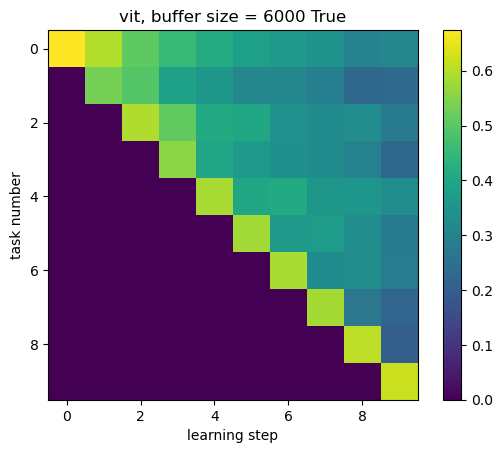

In [56]:
acc_heatmap(28)

In [57]:
from scipy.optimize import curve_fit

def exp_apprx(x, a, b, c):
    y = c * np.exp(- a * x) + b
    y[np.argwhere(y<0)] = 0
    return y


def fit_exp(buffer_size):
    num_runs = defaultdict(lambda: 0, {})
    acc = defaultdict(lambda: np.zeros((10, 10)), {})

    for i, run in enumerate(results):
        if run['buffer'] == buffer_size:
            acc[run['model']] += acc_matrix(i)
            num_runs[run['model']] += 1

    for key in acc.keys():
        acc[key] = acc[key] / num_runs[key]

    colors = mpl.colormaps['Set1'].colors
    
    fig, ax = plt.subplots(len(acc.keys()), 2, figsize=(10, 8))

    sorted_model_names = dict(sorted(acc.items()))

    for i, model in enumerate(sorted_model_names):
        for task_id in range(0, 6):
            x_data = range(0, 10 - task_id)
            y_data = acc[model][task_id, task_id:]
            params, err = curve_fit(exp_apprx, x_data, y_data)
            approx = exp_apprx(x_data, *params)
            a, b, c = params
            err = np.sqrt(np.diag(err)) 
            print(params,  err)

            color = colors[task_id]

            x_data_shifted = range(task_id, 10)
            ax[i][0].scatter(x_data_shifted, y_data, label=f"Task {task_id}", color=color)
            ax[i][0].plot(x_data_shifted, approx, linestyle="--", color=color)

            ax[i][0].fill_between(x_data_shifted, exp_apprx(x_data, a + err[0], b - err[1], c - err[2]), exp_apprx(x_data, a - err[0], b + err[1], c + err[2]), alpha=0.2, color=color)

            ax[i][1].scatter(task_id, a, color=color)
            ax[i][1].errorbar(task_id, a, yerr = err[0], color=color)

        ax[i][0].set_ylabel("Accuracy")
        ax[i][0].set_xlabel("Learning step")
        ax[i][1].set_xlabel("Task")
        ax[i][0].set_title(f"{model}, buffer {buffer_size}, averaged for {num_runs[model]} runs")
        ax[i][1].set_title("Exp decay rate a")
        ax[i][0].legend()

    plt.tight_layout()
    plt.setp(ax[:,1], ylim=(0, 3))
    plt.setp(ax[:,0], ylim=(0, 0.8))

    plt.show()

In [58]:
num_runs = len(results)

[0.27638479 0.22618037 0.35054178] [0.07394654 0.03504139 0.03380134]
[0.24096882 0.16196367 0.29735705] [0.08173818 0.0449067  0.04073136]
[0.53025716 0.27617245 0.26474068] [0.12815761 0.01816965 0.02407594]
[1.4399289  0.24093928 0.25810054] [0.51750847 0.0148826  0.03206301]
[2.0751557  0.2833835  0.24908066] [1.49995517 0.02212963 0.04638816]
[1.26684388 0.2268812  0.30786058] [0.40457735 0.02212223 0.03425526]
[0.21715442 0.25553888 0.40994431] [0.03134722 0.02606287 0.0234645 ]
[0.23074486 0.19730927 0.34156802] [0.07347303 0.04977585 0.04500697]
[0.41571438 0.29308957 0.30908391] [0.07209576 0.01805318 0.01952983]
[0.64976519 0.29163094 0.2623114 ] [0.13935575 0.01553448 0.02129704]
[1.04334218 0.3535709  0.24062615] [0.27998447 0.0146172  0.02407761]
[1.01090814 0.29266806 0.27669358] [0.45554788 0.03333143 0.04536923]


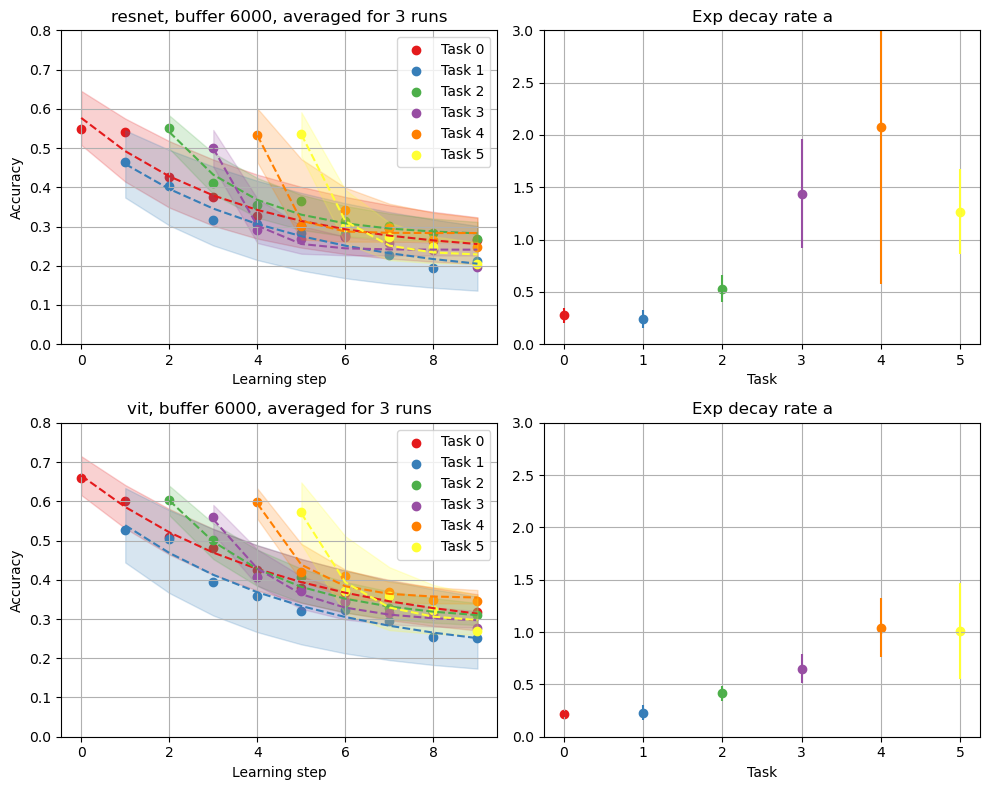

In [59]:
fit_exp(6000)

[0.21972213 0.1246906  0.45835451] [0.03736848 0.034069   0.03071142]
[0.25876276 0.10276781 0.36094524] [0.05755425 0.0341139  0.031249  ]
[0.47954197 0.20981422 0.34402252] [0.08431989 0.01842203 0.0223368 ]
[0.83395798 0.18483926 0.36830981] [0.21808037 0.0225366  0.037439  ]
[0.92968983 0.23652166 0.3741301 ] [0.22657036 0.02235372 0.03426801]
[1.02705352 0.21419055 0.40355681] [0.27649217 0.02870297 0.03945435]
[0.20608326 0.16161725 0.50814304] [0.0131566  0.01477638 0.01325403]
[0.24842564 0.1511232  0.3806197 ] [0.06377858 0.04265241 0.03882007]
[0.51791262 0.25580099 0.34931788] [0.08139027 0.01584561 0.02055773]
[0.79764844 0.23421939 0.38523623] [0.24125541 0.02806736 0.04518112]
[0.77244212 0.27143092 0.35938852] [0.22099866 0.02864327 0.03851324]
[0.96448104 0.24770144 0.39468279] [0.22848526 0.02587322 0.03419475]


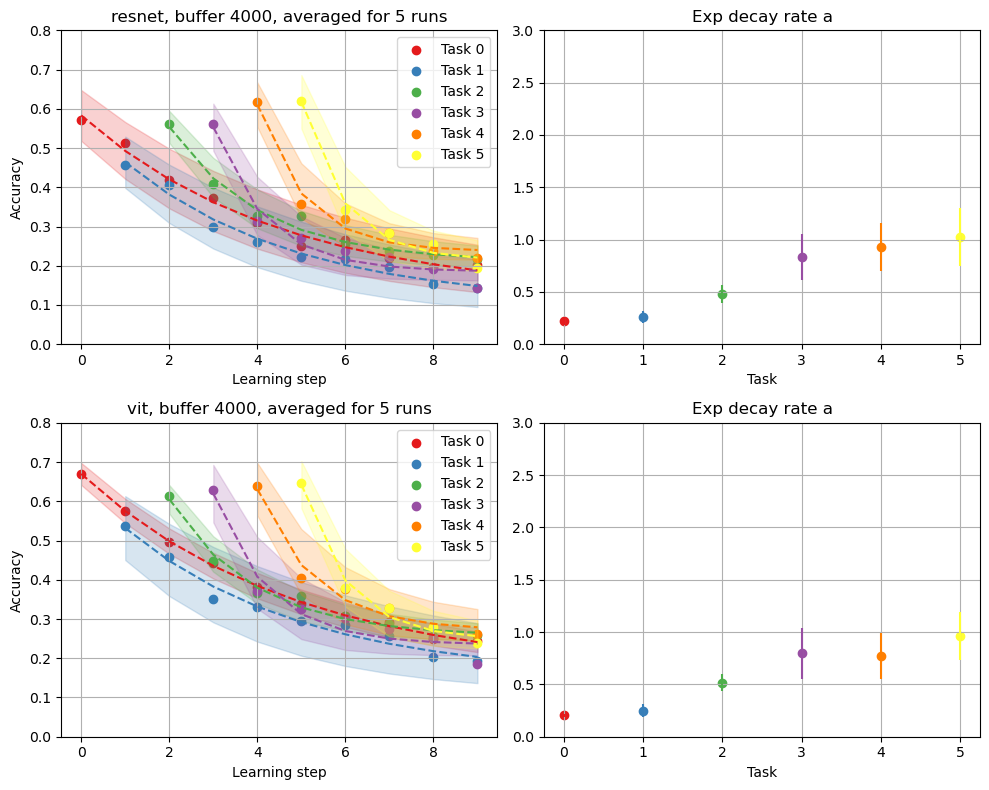

In [60]:
fit_exp(4000)

[0.31136491 0.08768996 0.46419216] [0.03481158 0.01780706 0.01848623]
[0.54541146 0.07846676 0.40562913] [0.10180044 0.01915888 0.02972151]
[0.85196108 0.14946114 0.44464049] [0.15386111 0.01678896 0.03228832]
[1.03789543 0.10160081 0.45165512] [0.15091978 0.01332743 0.02525455]
[1.44170306 0.16609963 0.47229367] [0.37966241 0.02209171 0.04226346]
[1.15328451 0.12394552 0.50205673] [0.28938376 0.03050209 0.04490815]
[0.34214657 0.14857313 0.49297036] [0.03582843 0.01654954 0.01852971]
[0.63494225 0.16218241 0.40261159] [0.11239922 0.01636308 0.02892252]
[0.92044891 0.20940413 0.4357775 ] [0.178233   0.01682269 0.03380503]
[1.08232565 0.16524633 0.49135042] [0.33497732 0.03001216 0.05806253]
[1.213043   0.21315948 0.4505966 ] [0.27801659 0.02098693 0.0374212 ]
[1.08840573 0.15097294 0.51727968] [0.34100636 0.04100368 0.05837769]


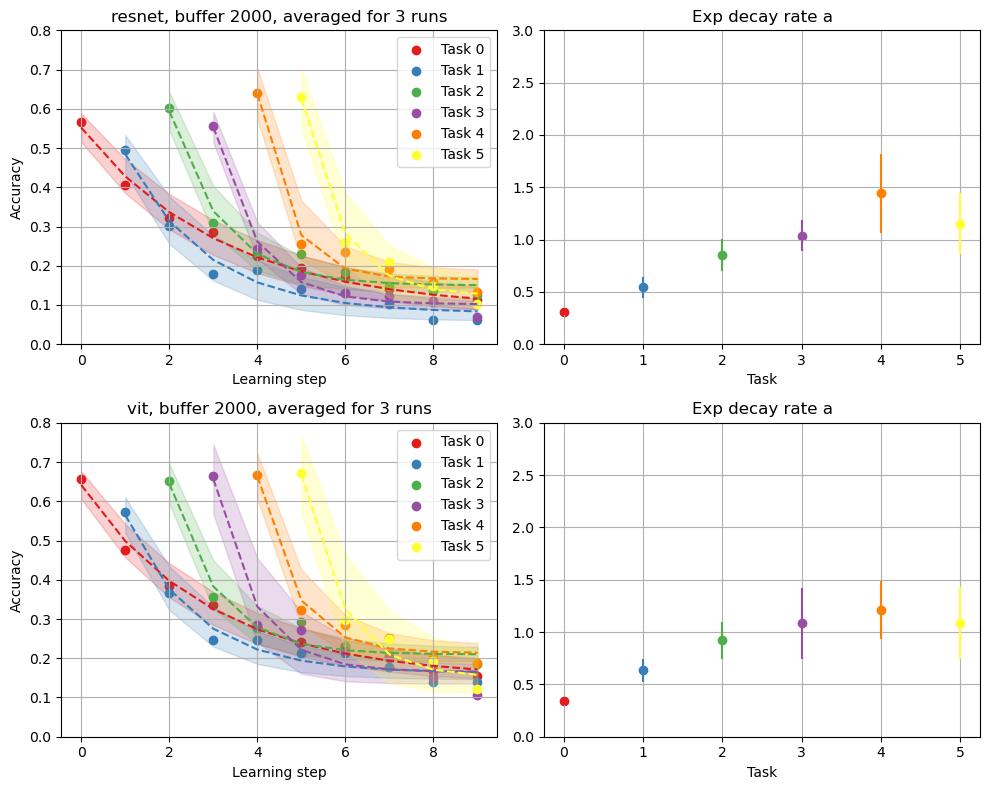

In [61]:
fit_exp(2000)

[1.05678301 0.06982783 0.46357115] [0.16608912 0.01152504 0.02951748]
[1.3463356  0.02987762 0.45129728] [0.11526667 0.0055663  0.01412292]
[1.49636764 0.13804761 0.40594084] [0.25578792 0.00991173 0.02373963]
[2.28344175 0.04076053 0.31903913] [0.41653471 0.00572725 0.01346186]
[2.33750013 0.04512948 0.34137322] [0.61278714 0.00936486 0.01998399]
[2.03185012 0.02520436 0.35946389] [0.48840151 0.01228356 0.02253628]
[0.64322388 0.1247296  0.5139671 ] [0.09497371 0.01598132 0.03192836]
[0.98190041 0.10573552 0.46776916] [0.10918405 0.00920233 0.02112364]
[1.26388034 0.1529758  0.51210468] [0.16288201 0.01071301 0.02454147]
[1.83721184 0.10226484 0.56728529] [0.25447409 0.01007847 0.02295987]
[2.0228706  0.12318835 0.5825263 ] [0.37079488 0.01354015 0.02825708]
[1.68113443 0.077337   0.60192374] [0.43120513 0.02706489 0.04714645]


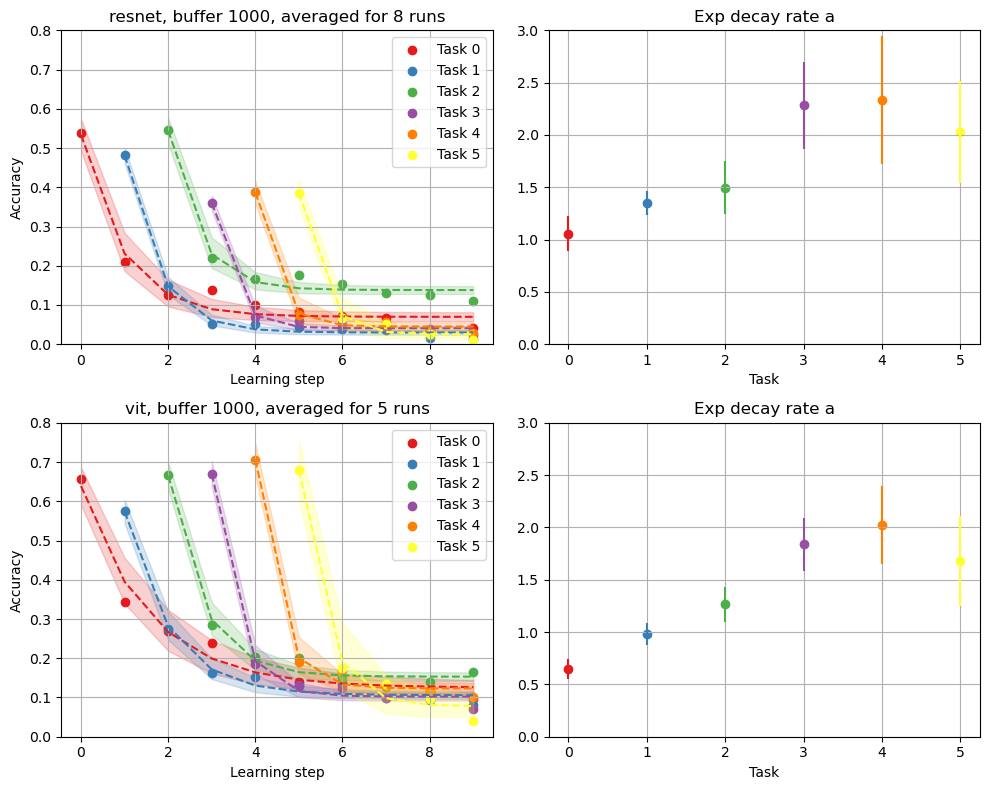

In [62]:
fit_exp(1000)

In [63]:
def fit_exp_custom(buffer_size, run_ids):
    num_runs = defaultdict(lambda: 0, {})
    acc = defaultdict(lambda: np.zeros((10, 10)), {})

    for run_id in run_ids:
        run = results[run_id]

        if run['buffer'] == buffer_size:
            acc[run['model']] += acc_matrix(run_id)
            num_runs[run['model']] += 1

    for key in acc.keys():
        acc[key] = acc[key] / num_runs[key]

    colors = mpl.colormaps['Set1'].colors
    
    fig, ax = plt.subplots(len(acc.keys()), 2, figsize=(10, 8))

    sorted_model_names = dict(sorted(acc.items()))

    for i, model in enumerate(sorted_model_names):
        for task_id in range(0, 6):
            x_data = range(0, 10 - task_id)
            y_data = acc[model][task_id, task_id:]
            params, err = curve_fit(exp_apprx, x_data, y_data)
            approx = exp_apprx(x_data, *params)
            a, b, c = params
            err = np.sqrt(np.diag(err)) 
            print(params,  err)

            color = colors[task_id]

            x_data_shifted = range(task_id, 10)
            ax[i][0].scatter(x_data_shifted, y_data, label=f"Task {task_id}", color=color)
            ax[i][0].plot(x_data_shifted, approx, linestyle="--", color=color)

            ax[i][0].fill_between(x_data_shifted, exp_apprx(x_data, a + err[0], b - err[1], c - err[2]), exp_apprx(x_data, a - err[0], b + err[1], c + err[2]), alpha=0.2, color=color)

            ax[i][1].scatter(task_id, a, color=color)
            ax[i][1].errorbar(task_id, a, yerr = err[0], color=color)

        ax[i][0].set_ylabel("Accuracy")
        ax[i][0].set_xlabel("Learning step")
        ax[i][1].set_xlabel("Task")
        ax[i][0].set_title(f"{model}, buffer {buffer_size}, averaged for {num_runs[model]} runs")
        ax[i][1].set_title("Exp decay rate a")
        ax[i][0].legend()

    plt.tight_layout()
    plt.setp(ax[:,1], ylim=(0, 3))
    plt.setp(ax[:,0], ylim=(0, 0.8))

    plt.show()

[44, 45]
[0.32308883 0.2299247  0.36633731] [0.08034752 0.03043375 0.03249339]
[0.32890962 0.15838731 0.31265682] [0.08227736 0.0281705  0.02827277]
[0.3358222  0.19622133 0.35432004] [0.11429374 0.04714577 0.04528444]
[2.40020607 0.25392383 0.33946736] [1.54031015 0.0199437  0.04712868]
[0.60160619 0.20598049 0.42441905] [0.17754797 0.04154394 0.04670486]
[1.09093304 0.22676679 0.39770046] [0.26409766 0.02431492 0.03466568]
[0.23413011 0.1857476  0.4672585 ] [0.0378575  0.03165644 0.02882545]
[ 0.12385899 -0.00893153  0.53103019] [0.08105143 0.2202221  0.2081063 ]
[0.58685955 0.25655571 0.36073998] [0.09910269 0.01614973 0.02342362]
[0.87499877 0.2559144  0.35417148] [0.42911486 0.03939261 0.06758876]
[0.74856396 0.27130545 0.34230092] [0.369362   0.04808606 0.06317014]
[1.12272915 0.25656214 0.41454809] [0.16847587 0.01537306 0.02228913]


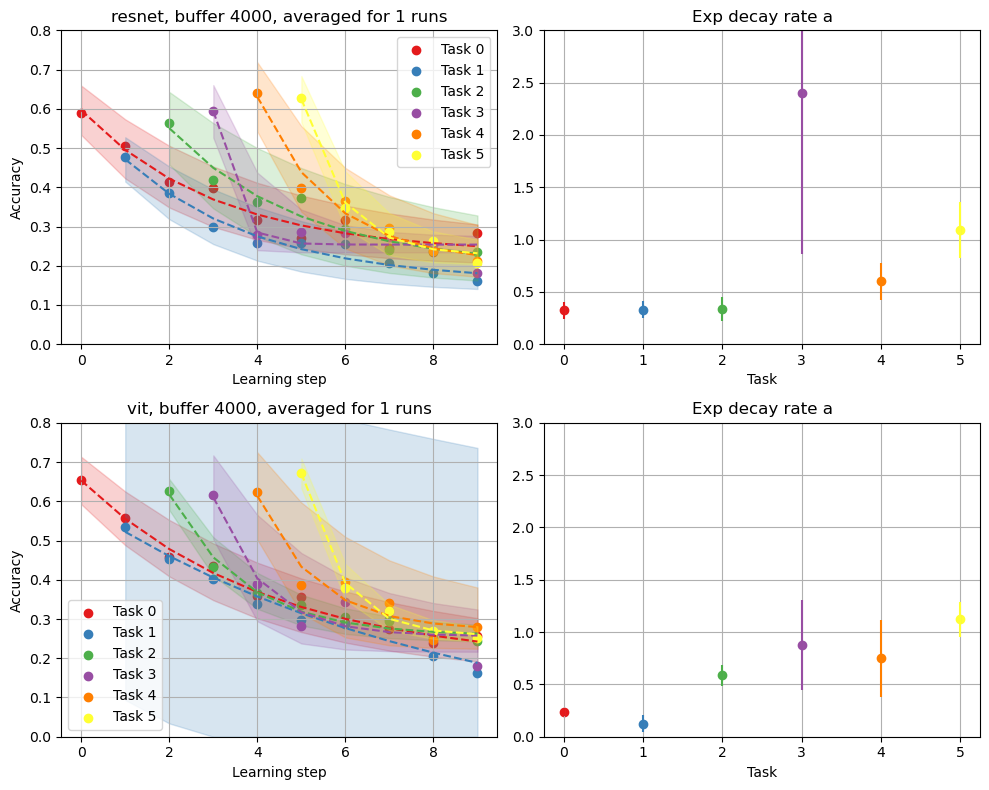

In [64]:
run_ids = []
for i, run in enumerate(results):
    if 'lr_mode' in run.keys() and run['lr_mode'] == 'const':
        
        run_ids.append(i)

print(run_ids)

fit_exp_custom(4000, run_ids)

[46, 47]
[0.15750419 0.0903493  0.46750881] [0.04059017 0.06430771 0.05840621]
[0.22053344 0.12688926 0.34100915] [0.110898   0.0807126  0.07288067]
[0.54151306 0.24957111 0.34465435] [0.08661331 0.01543244 0.02083588]
[0.82495226 0.19568478 0.38263189] [0.2082334  0.02276003 0.03752601]
[0.93312827 0.28499584 0.32235936] [0.42612863 0.03599788 0.05532015]
[0.92987926 0.2187818  0.41560658] [0.28289822 0.03593636 0.04640583]
[0.1821028  0.12728638 0.56175907] [0.02410825 0.03655295 0.03282095]
[0.35722416 0.20998987 0.34592849] [0.10588757 0.0348253  0.03691828]
[0.53966093 0.25200622 0.3798667 ] [0.06722717 0.01327799 0.01787247]
[0.87854145 0.23909346 0.40335544] [0.29383985 0.03051695 0.05249768]
[0.90379965 0.27656124 0.34302684] [0.28444127 0.02698688 0.04059443]
[0.90406403 0.24077725 0.42628973] [0.11404484 0.01560092 0.01978785]


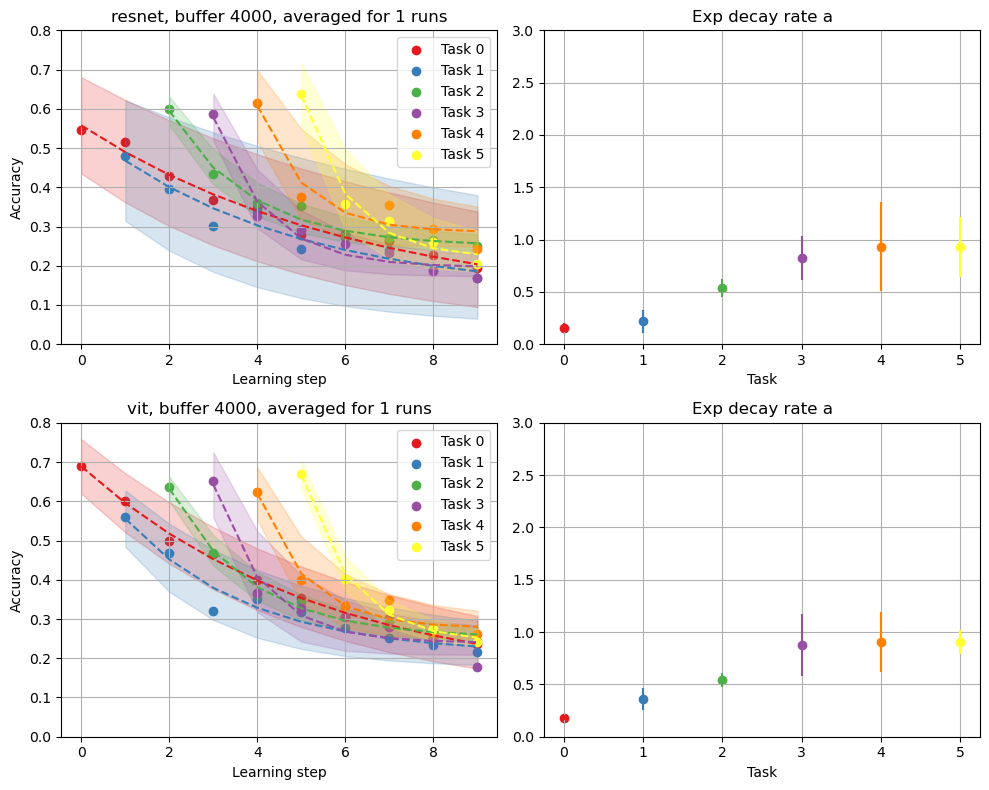

In [65]:
run_ids = []
for i, run in enumerate(results):
    if 'lr_mode' in run.keys() and run['lr_mode'] == 'cyclic':
        
        run_ids.append(i)

print(run_ids)

fit_exp_custom(4000, run_ids)